In [118]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from torch.utils.tensorboard import SummaryWriter

## Build an unique dataset based on the PM25's median
1- Aggregate each data sensors hourly by applying a mean
2- Create an unique dataset by applying a median of each sensor in each hour

### Define constants and hyperparameters

In [13]:
START_DATE_BOARD    = '2022-11-03'
END_DATE_BOARD      = '2023-06-15'
PM25_DIRECTORY      = '../resources/dataset/'
PM2_MAP = {
    "board20": ["s250.csv", "s252.csv", "s256.csv", "s258.csv"],
    "board21": ["s263.csv", "s265.csv", "s267.csv", "s269.csv"],
    "board22": ["s276.csv", "s278.csv", "s280.csv", "s282.csv"],
    "board25": ["s315.csv", "s317.csv", "s319.csv", "s321.csv"],
    "board29": ["s367.csv", "s369.csv", "s371.csv", "s373.csv"],
    "board31": ["s393.csv", "s395.csv", "s397.csv", "s399.csv"]
}

# Define the hyperparameter
TRAIN_SIZE      = 0.7
RANDOM_STATE    = 42
INPUT_SIZE      = 60
HIDDEN_SIZE     = 128
OUTPUT_SIZE     = 1
LEARNING_RATE   = 0.0001
NUM_EPOCHS      = 200
BATCH_SIZE      = 20


torch.manual_seed(RANDOM_STATE)

### Transform each CSV into Pandas dataframe

In [5]:
def prepare_pm25_dataframe(file_name: str) -> pd.DataFrame:
    df_pm25             = pd.read_csv(file_name) #mu_g/m^3
    df_pm25.timestamp   = pd.to_datetime(df_pm25.timestamp)
    df_pm25.drop_duplicates(inplace=True)
    df_pm25.sort_values(by='timestamp', inplace=True)
    df_pm25 = df_pm25.loc[(df_pm25['timestamp'] >= START_DATE_BOARD) & (df_pm25['timestamp'] <= END_DATE_BOARD)]
    df_pm25 = df_pm25.groupby(pd.Grouper(key='timestamp', freq='min')).mean().reset_index()
    df_pm25.dropna(inplace=True)
    return df_pm25

dataframes = []
for folder_name in tqdm(os.listdir(PM25_DIRECTORY), desc='Analyzing folders'):
    folder = os.path.join(PM25_DIRECTORY, folder_name)
    if os.path.isdir(folder) and len(folder.split('/')) > 3 and folder.split('/')[3] in PM2_MAP:
        files = PM2_MAP[folder.split('/')[3]]
        for file_name in files:
            file = os.path.join(folder, file_name)
            if os.path.isfile(file) and file.endswith(".csv"):
                df_pm25 = prepare_pm25_dataframe(file)
                dataframes.append(df_pm25)

Analyzing folders: 100%|██████████| 9/9 [07:52<00:00, 52.49s/it]


### Get an unique dataframe by applying the median in each point

In [6]:
df_pm25                 = pd.DataFrame(columns=['timestamp', 'data'])
df_pm25['timestamp']    = pd.date_range(start=START_DATE_BOARD, end=END_DATE_BOARD, freq='min')
pm25_series             = []

for pit in tqdm(df_pm25['timestamp'], desc='Building unique dataset'):
    pm25_values = []
    for df in dataframes:
        value = df[df.timestamp == pit]['data'].values
        if len(value) > 0:
            pm25_values.append(value[0])
        #else:
        #    pm25_values.append(0)
    pm25_series.append(np.median(pm25_values) if len(pm25_values) > 0 else None)

df_pm25['data']    = pd.Series(pm25_series)
df_pm25.dropna(inplace=True)
df_pm25.to_csv('../resources/dataset/unique_timeseries_by_median_minutes.csv', index=False)

Building unique dataset: 100%|██████████| 322561/322561 [2:03:46<00:00, 43.43it/s]  


### Prepare dataset

In [14]:
def change_hour_format(hour: str) -> str:
    return hour + ":00" if len(hour.split(':')) <= 2 else hour

def build_arpa_dataset(arpa_2022:str, arpa_2023:str) -> pd.DataFrame:
    df_arpa_2022 = pd.read_csv(arpa_2022, sep=';')
    df_arpa_2023 = pd.read_csv(arpa_2023, sep=';', index_col=False)
    df_arpa_2022.dropna(inplace=True)
    df_arpa_2023 = df_arpa_2023[df_arpa_2023.Stato == 'V']

    df_arpa = pd.DataFrame(columns=['timestamp', 'pm25'])
    data_series_2022 = df_arpa_2022['Data'] + " " + df_arpa_2022['Ora'].map(lambda x: change_hour_format(x))
    data_series_2023 = df_arpa_2023['Data rilevamento'] + ' ' + df_arpa_2023['Ora'].map(lambda x: change_hour_format(x))
    pm25_series = df_arpa_2022['PM2.5']

    data_series = pd.concat([data_series_2022, data_series_2023], ignore_index = True)
    pm25_series = pd.concat([pm25_series, df_arpa_2023['Valore']], ignore_index = True)

    df_arpa['timestamp']    = data_series
    df_arpa['pm25']         = pm25_series
    df_arpa.timestamp       = pd.to_datetime(df_arpa.timestamp, format="%d/%m/%Y %H:%M:%S")
    # Apply date range filter
    mask = (df_arpa['timestamp'] >= START_DATE_BOARD) & (df_arpa['timestamp'] <= END_DATE_BOARD)
    df_arpa = df_arpa.loc[mask]

    # Apply a special filter in which I remove all ARPA's values below 4
    df_arpa = df_arpa[df_arpa['pm25'] > 4]
    return df_arpa

def slide_plus_1hours(y: pd.Series, init_value: float) -> pd.Series:
    y_plus_1hour = y.copy()
    y_plus_1hour[0] = init_value
    for idx in range(1, len(y)):
        v = y[idx - 1]
        y_plus_1hour[idx] = v
    return y_plus_1hour

In [117]:
class PM25AnnDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, batch_size):
        self._batch_size    = batch_size
        self.X              = X
        self.y              = y
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i*self._batch_size : (i+1)*self._batch_size], self.y[i]

class PM25AnnDataset2(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X              = X
        self.y              = y
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [16]:
df_sensors              = pd.read_csv('../resources/dataset/unique_timeseries_by_median_minutes.csv')
df_sensors.timestamp    = pd.to_datetime(df_sensors.timestamp)
df_sensors.timestamp    += pd.Timedelta(minutes = 1)
df_arpa                 = build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv'
                                             , '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv')
# Apply date range filter (inner join)
mask = (df_arpa['timestamp'] >= min(df_sensors.timestamp) + pd.DateOffset(hours=1)) & (df_arpa['timestamp'] <= max(df_sensors.timestamp))
df_arpa                 = df_arpa.loc[mask]
mask = (df_sensors['timestamp'] >= min(df_arpa.timestamp) - pd.DateOffset(hours=1)) & (df_sensors['timestamp'] <= max(df_arpa.timestamp))
df_sensors              = df_sensors.loc[mask]
# Slide ARPA data 1 hour plus
df_arpa.reset_index(inplace=True)
df_arpa['pm25']         = slide_plus_1hours(df_arpa['pm25'], df_arpa['pm25'][0])

#### Prepare dataset: approach 1

In [5]:
# Unique dataset
df                      = df_sensors.merge(df_arpa, how='left', on='timestamp').drop(['index'], axis=1)

X               = df['data'].values
y               = df['pm25'].dropna().values
X_train         = X[ : int(len(X)*TRAIN_SIZE)]
X_test          = X[int(len(X)*TRAIN_SIZE) : ]
y_train         = y[ : int(len(y)*TRAIN_SIZE)]
y_test          = y[int(len(y)*TRAIN_SIZE) : ]
# Convert to 2D PyTorch tensors
X_train         = torch.tensor(X_train, dtype=torch.float32)
y_train         = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test          = torch.tensor(X_test, dtype=torch.float32)
y_test          = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
# Convert into my dataset cutom class
train_dataset   = PM25AnnDataset(X_train, y_train, INPUT_SIZE)
test_dataset    = PM25AnnDataset(X_test, y_test, INPUT_SIZE)
# Use data-loader in order to have batches
train_loader    = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, sampler=SequentialSampler(train_dataset))
test_loader     = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, sampler=SequentialSampler(test_dataset))

In [15]:
df.head(20)

,timestamp,data,pm25
0,2022-11-03 16:00:00,22.325000,NaN
1,2022-11-03 16:01:00,22.750000,NaN
2,2022-11-03 16:02:00,22.425000,NaN
3,2022-11-03 16:03:00,21.950000,NaN
4,2022-11-03 16:04:00,22.220238,NaN
5,2022-11-03 16:05:00,21.883333,NaN
6,2022-11-03 16:06:00,21.716667,NaN
7,2022-11-03 16:07:00,21.991667,NaN
8,2022-11-03 16:08:00,22.472619,NaN
9,2022-11-03 16:09:00,22.677273,NaN


#### Prepare dataset approach 2

In [71]:
# Unique dataset
columns = ["tm{}".format(i) for i in range(1, 61)]
columns.insert(0, 'arpa')
df = pd.DataFrame(columns=columns)

df_sensors.reset_index(inplace=True, drop=True)
for i, arpa in enumerate(df_arpa['pm25']):
    row = df_sensors['data'][i * 60: (i+1) * 60].values
    row = np.append(arpa, row)
    df.loc[len(df)] = row.tolist()

df.head()

,arpa,tm1,tm2,tm3,tm4,tm5,tm6,tm7,tm8,tm9,...,tm51,tm52,tm53,tm54,tm55,tm56,tm57,tm58,tm59,tm60
0,20.0,22.315152,22.325000,22.750000,22.425000,21.950000,22.220238,21.883333,21.716667,21.991667,...,23.341667,23.600000,23.508333,23.583333,22.849020,23.350000,23.331982,24.091667,24.533333,24.791667
1,20.0,23.923958,24.016667,24.166667,24.516667,23.750000,23.966667,24.000000,24.350000,23.941667,...,25.497674,26.291667,25.770325,24.779505,26.220122,26.175000,26.233333,27.341667,26.741667,26.891667
2,13.0,26.600000,26.625000,26.633333,26.341667,27.360714,26.583333,26.236111,27.041667,26.625000,...,21.408333,22.183333,22.191667,21.875000,20.958333,20.316667,18.841667,17.916667,16.808333,14.158333
3,18.0,13.550000,12.525000,11.275000,11.225000,11.000000,10.541667,10.716667,10.108333,9.941667,...,7.683333,7.600000,7.891667,8.050000,7.958333,8.259524,8.358333,8.783333,8.483333,8.808333
4,19.0,8.916667,8.941667,8.675000,9.008333,8.825000,8.591667,8.625000,8.583333,8.166667,...,9.211782,9.341667,9.356897,9.450000,9.532292,9.233333,8.875000,9.266667,9.608333,9.541667


In [151]:
X = df.loc[:, df.columns != "arpa"]
y = df['arpa']
print(len(y), len(X))
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=TRAIN_SIZE, shuffle=False, random_state=RANDOM_STATE)
# Convert to 2D PyTorch tensors
X_train         = torch.tensor(X_train, dtype=torch.float32)
y_train         = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test          = torch.tensor(X_test, dtype=torch.float32)
y_test          = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
# Convert into my dataset cutom class
train_dataset   = PM25AnnDataset2(X_train, y_train)
test_dataset    = PM25AnnDataset2(X_test, y_test)
# Use data-loader in order to have batches
train_loader    = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0, sampler=RandomSampler(train_dataset))
test_loader     = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, sampler=RandomSampler(test_dataset))

3990 3990


### Create the model structure

**Hyperparameters**:
- the size of the hidden layers
- the activation function

In [152]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 90),
            nn.ReLU(),
            nn.Linear(90, 30),
            nn.ReLU(),
            nn.Linear(30, output_size),
        )

    def forward(self, x):
        out = self.net(x)
        return out

### Train the model

In [153]:
# Instantiate the model
model           = MyNeuralNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE)
# Define the loss function and optimizer
criterion       = nn.MSELoss()
optimizer       = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [154]:
# Train the model
train_losses    = np.zeros(NUM_EPOCHS)
test_losses     = np.zeros(NUM_EPOCHS)
writer          = SummaryWriter('../runs/ann_notebook_1')

for epoch in tqdm(range(NUM_EPOCHS), desc='Train the model'):
    model.train()
    current_loss        = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets         = targets.reshape((targets.shape[0], 1))
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs         = model(inputs)
        loss            = criterion(outputs, targets)
        # Backpropagation
        loss.backward()
        optimizer.step()
        current_loss    += loss.item()
        # Write the network graph at epoch 0, batch 0
        if epoch == 0 and i == 0:
            writer.add_graph(model, input_to_model=data[0], verbose=False)
    
    train_losses[epoch] = current_loss
    writer.add_scalar("ANN - Loss/train", current_loss, epoch)
    
    # Evaluate accuracy at end of each epoch
    model.eval()
    current_loss        = 0.0
    for i, data in enumerate(test_loader, 0):
        inputs, targets     = data
        inputs, targets     = inputs.float(), targets.float()
        targets             = targets.reshape((targets.shape[0], 1))
        y_pred              = model(inputs)
        test_loss           = criterion(y_pred, targets)
        current_loss        += test_loss.item()
        
    test_losses[epoch]  = current_loss
    writer.add_scalar("ANN - Loss/test", current_loss, epoch)

# Save the model at the end of the training (for future inference)
torch.save(model.state_dict(), os.path.join('checkpoints', 'ann', 'ann_notebook_1.pt'))
writer.flush()
writer.close()

Train the model: 100%|██████████| 200/200 [13:46<00:00,  4.13s/it]


### Draw the train loss at each iteration

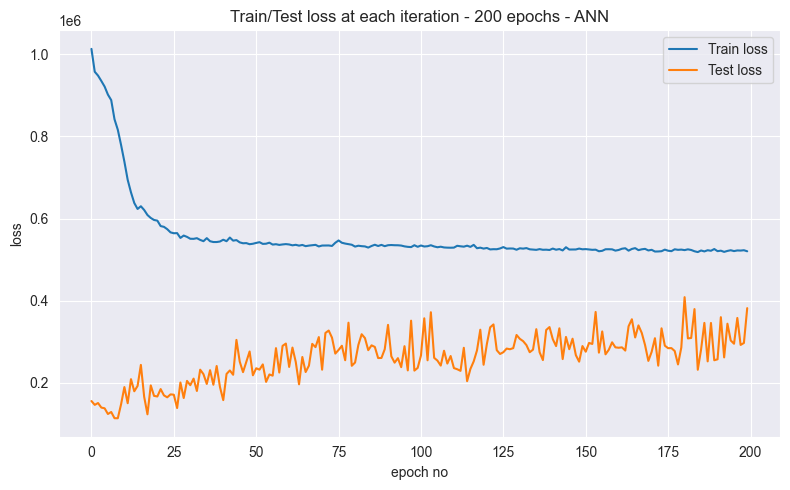

In [155]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_losses, label='Train loss')
ax.plot(test_losses, label='Test loss')
ax.set_xlabel('epoch no')
ax.set_ylabel('loss')
ax.set_title(f'Train/Test loss at each iteration - {NUM_EPOCHS} epochs - ANN')
ax.legend()
plt.tight_layout()
plt.show()

### Draw the performance

In [156]:
test_target         = y_test.cpu().detach().numpy()
test_predictions    = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(len(test_target)), desc='Preparing predictions'):
        input_      = X_test[i].float()
        y_pred      = model(input_)
        test_predictions.append(y_pred.item())
    '''for i, data in enumerate(test_loader, 0):
        inputs, targets     = data
        inputs, targets     = inputs.float(), targets.float()
        targets             = targets.reshape((targets.shape[0], 1))
        y_pred              = model(inputs)
        test_predictions.append(y_pred)'''

plot_len        = len(test_predictions)
plot_df         = df_arpa[['timestamp', 'pm25']].copy(deep=True)#df[['timestamp', 'pm25']].copy(deep=True)
plot_df         = plot_df.iloc[-plot_len:]
plot_df['pred'] = test_predictions
plot_df.set_index('timestamp', inplace=True)

Preparing predictions: 100%|██████████| 1197/1197 [00:00<00:00, 9844.57it/s]


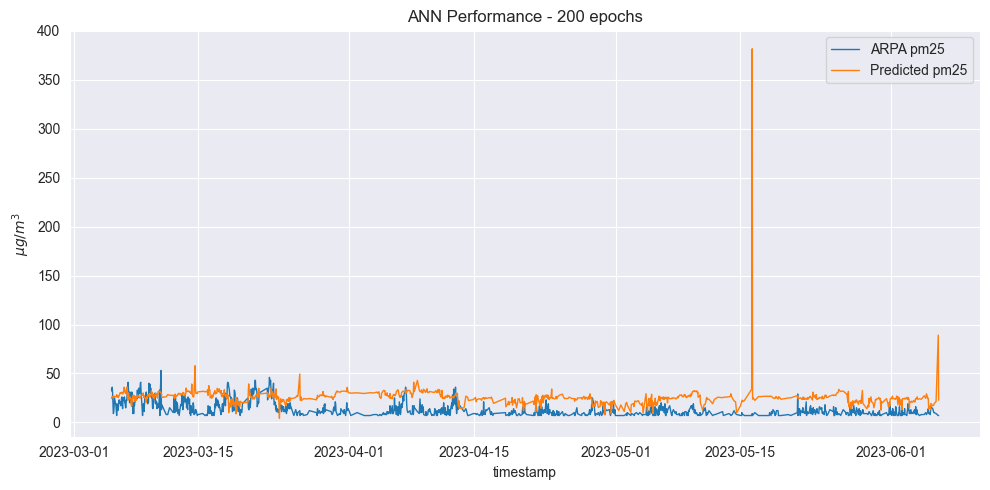

In [157]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(plot_df['pm25'], label='ARPA pm25', linewidth=1)
ax.plot(plot_df['pred'], label='Predicted pm25', linewidth=1)
ax.set_xlabel('timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'ANN Performance - {NUM_EPOCHS} epochs')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()